# Convolutional Neural Networks
This notebook will guide you through the use of the `keras` package to train convolutional neural networks for handwritten digits classification. You are going to use the `mnist` dataset from LeCun et al. 1998.

## Loading the packages

In [1]:
import numpy as np
from matplotlib import pyplot as pl

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow import keras as keras
from keras.models import Model
from sklearn import metrics as me
from scipy import stats


%matplotlib inline

2022-05-04 12:53:35.507594: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-04 12:53:35.507636: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Load the `mnist` dataset and normalize in the range [0, 1]

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape

X_train = np.expand_dims(X_train, axis=3).astype(np.float32)
X_test = np.expand_dims(X_test, axis=3).astype(np.float32)

X_train /= 255.0
X_test /= 255.0

n_classes = 10

print(n_train, 'train samples')
print(n_test, 'test samples')

# convert class vectors to binary class matrices
Y_train = keras.utils.to_categorical(y_train, n_classes)
Y_test = keras.utils.to_categorical(y_test, n_classes)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

60000 train samples
10000 test samples
(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)


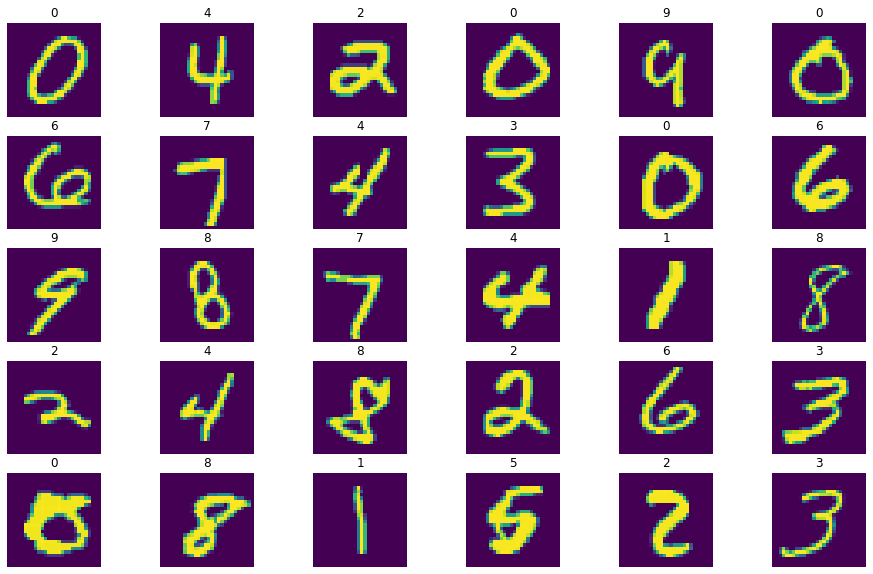

In [3]:
pl.figure(figsize=(16,10))
for i in range(30):
    pl.subplot(5,6,i+1)
    j = np.random.randint(0,X_train.shape[0])
    pl.imshow(X_train[j,:,:,0])
    pl.title(y_train[j])
    pl.axis('off')

### Make sure that the dimension ordering matches the backend (tensorflow)

In [4]:
print(keras.backend.image_data_format())

channels_last


### Create the CNN and show its architecture (Functional API)

In [38]:
l0 = keras.layers.Input(shape=(height, width, 1), name='l0')

l1 = keras.layers.Conv2D(8, (5, 5), padding='same', activation='relu', name='l1')(l0)
l1_mp = keras.layers.MaxPooling2D(pool_size=(2, 2), name='l1_mp')(l1)

l2 = keras.layers.Conv2D(9, (5, 5), padding='same', activation='relu', name='l2')(l1_mp)
l2_mp = keras.layers.MaxPooling2D(pool_size=(2, 2), name='l2_mp')(l2)

l3 = keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu', name='l3')(l2_mp)
l3_mp = keras.layers.MaxPooling2D(pool_size=(2, 2), name='l3_mp')(l3)

flat = keras.layers.Flatten(name='flat')(l3_mp)

l4 = keras.layers.Dense(25, activation='relu', name='l4')(flat)

l5 = keras.layers.Dense(n_classes, activation='softmax', name='l5')(l4)

model = keras.models.Model(inputs=l0, outputs=l5)
model.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 l0 (InputLayer)             [(None, 28, 28, 1)]       0         
                                                                 
 l1 (Conv2D)                 (None, 28, 28, 8)         208       
                                                                 
 l1_mp (MaxPooling2D)        (None, 14, 14, 8)         0         
                                                                 
 l2 (Conv2D)                 (None, 14, 14, 9)         1809      
                                                                 
 l2_mp (MaxPooling2D)        (None, 7, 7, 9)           0         
                                                                 
 l3 (Conv2D)                 (None, 7, 7, 16)          1312      
                                                                 
 l3_mp (MaxPooling2D)        (None, 3, 3, 16)          0  

### Define some constants and train de CNN

In [39]:
batch_size = 128
n_epoch = 10

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(), metrics=['accuracy'])

history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epoch, verbose=1,
                    validation_data=(X_test, Y_test))

Epoch 1/10
469/469 [==============================] - 16s 33ms/step - loss: 1.8838 - accuracy: 0.4008 - val_loss: 0.7210 - val_accuracy: 0.7771
Epoch 2/10
469/469 [==============================] - 15s 32ms/step - loss: 0.4739 - accuracy: 0.8535 - val_loss: 0.3356 - val_accuracy: 0.8975
Epoch 3/10
469/469 [==============================] - 15s 32ms/step - loss: 0.2767 - accuracy: 0.9149 - val_loss: 0.2311 - val_accuracy: 0.9311
Epoch 4/10
469/469 [==============================] - 15s 32ms/step - loss: 0.2076 - accuracy: 0.9372 - val_loss: 0.1697 - val_accuracy: 0.9469
Epoch 5/10
469/469 [==============================] - 15s 32ms/step - loss: 0.1732 - accuracy: 0.9470 - val_loss: 0.1419 - val_accuracy: 0.9556
Epoch 6/10
469/469 [==============================] - 15s 32ms/step - loss: 0.1484 - accuracy: 0.9539 - val_loss: 0.1459 - val_accuracy: 0.9560
Epoch 7/10
469/469 [==============================] - 15s 32ms/step - loss: 0.1333 - accuracy: 0.9584 - val_loss: 0.1281 - val_accuracy:

### Show the performance of the model

Test score: 0.09579398483037949
Test accuracy: 0.9675999879837036


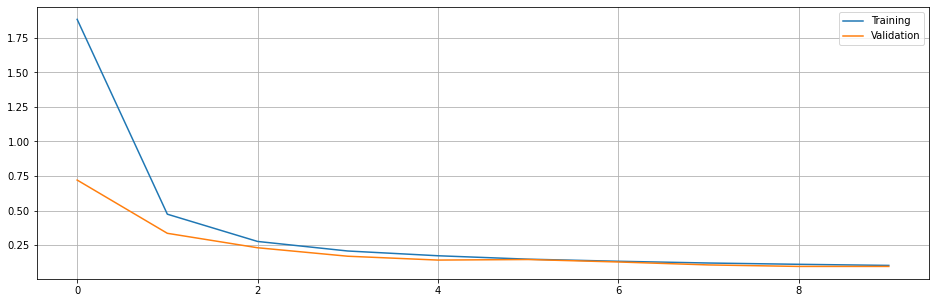

In [40]:
pl.figure(figsize=(16,5))
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Validation')
pl.legend()
pl.grid()

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

### Confusion matrix

In [41]:
pred_probas = model.predict_on_batch(X_test)
pred_classes = np.argmax(pred_probas, axis=-1)
me.confusion_matrix(y_test, pred_classes)

array([[ 967,    0,    1,    0,    0,    4,    3,    1,    3,    1],
       [   0, 1119,    2,    2,    1,    2,    2,    1,    5,    1],
       [   6,    3,  990,   20,    1,    1,    0,    4,    7,    0],
       [   0,    0,    0,  996,    0,    4,    0,    3,    3,    4],
       [   1,    1,    3,    0,  938,    0,    3,    2,    4,   30],
       [   3,    1,    0,   16,    2,  857,    1,    1,    5,    6],
       [  12,    2,    1,    0,    4,   10,  929,    0,    0,    0],
       [   1,    4,   11,   10,    2,    0,    0,  969,    5,   26],
       [   2,    0,    2,   17,    3,    6,    2,    1,  935,    6],
       [   3,    3,    1,   12,    6,    2,    0,    3,    3,  976]])

-------------------

In [42]:
def build_grid_of_images(array):
    assert len(array.shape) == 3
    array = np.rollaxis(array, 2, 0)
    dim_0 = np.sqrt(array.shape[0])
    if dim_0.is_integer():
        dim_0 = int(dim_0)
    else:
        new_dim_0 = int(np.ceil(dim_0))
        array = np.vstack([array, np.zeros(((new_dim_0**2)-array.shape[0],array.shape[1], array.shape[2]))])
        dim_0 = new_dim_0
    
    temp_out = np.reshape(array, (dim_0, dim_0, array.shape[1], array.shape[2]))
    temp_out = np.rollaxis(temp_out, 1, 3)
    return np.reshape(temp_out, (dim_0*array.shape[1], dim_0*array.shape[2]))

def plot_conv_layer_output(temp_out, title):
    temp_to_plot = build_grid_of_images(temp_out)
    pl.imshow(temp_to_plot, interpolation='nearest', cmap=pl.get_cmap('Greys'))
    ax = pl.gca()
    ax.set_xticks(np.arange(-0.5, temp_to_plot.shape[0]+0.5, temp_out.shape[0]))    
    ax.set_yticks(np.arange(-0.5, temp_to_plot.shape[0]+0.5, temp_out.shape[1]))
    pl.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    pl.grid()
    pl.title(title)

def plot_dense_layer_output(temp_out, title):
    pl.bar(np.arange(temp_out.shape[1])-0.4, temp_out[0,:])
    pl.xlim(-0.5, temp_out.shape[1])
    pl.grid()
    pl.title(title)

## Testing the behaviour of each layer

Artificial neural networks are considered black-box models in which it is very difficult to understand the meaning of the model parameters (weights).
The following cells show some approaches which should ease the understanding of how a CNN works, or what kind of features are encoded in the internal filters of the network

In [43]:
l1_o = Model(inputs=l0, outputs=l1)
l1_mp_o = Model(inputs=l0, outputs=l1_mp)
l2_o = Model(inputs=l0, outputs=l2)
l2_mp_o = Model(inputs=l0, outputs=l2_mp)
l3_o = Model(inputs=l0, outputs=l3)
l3_mp_o = Model(inputs=l0, outputs=l3_mp)
flat_o = Model(inputs=l0, outputs=flat)
l4_o = Model(inputs=l0, outputs=l4)
l5_o = Model(inputs=l0, outputs=l5)

Do the test with one input from the test set

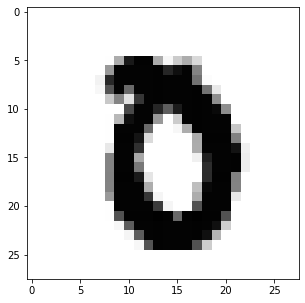

In [44]:
class_target = 0                                    # select the class to be visualized

mask = Y_test[:,class_target] > 0.5
sample = np.random.choice(np.where(mask)[0],1)[0]   # choose a random sample of the selected class
current_input = X_test[sample:(sample+1),:,:,0:1]

pl.figure(figsize=(5,5))
pl.imshow(current_input[0,:,:,0], interpolation='nearest', cmap=pl.get_cmap('Greys'))

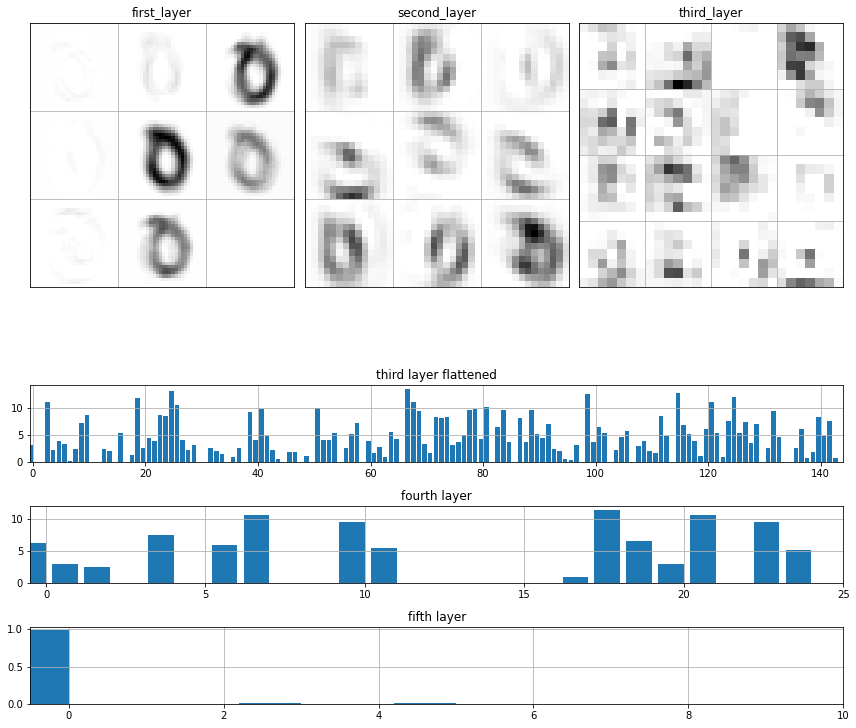

In [45]:
pl.figure(figsize=(12,10))

pl.subplot(2,3,1)
temp_out = l1_o.predict(current_input)[0,:,:,:]
plot_conv_layer_output(temp_out, 'first_layer')

pl.subplot(2,3,2)
temp_out = l2_o.predict(current_input)[0,:,:,:]
plot_conv_layer_output(temp_out, 'second_layer')

pl.subplot(2,3,3)
temp_out = l3_o.predict(current_input)[0,:,:,:]
plot_conv_layer_output(temp_out, 'third_layer')

pl.subplot(6,1,4)
temp_out = flat_o.predict(current_input)
plot_dense_layer_output(temp_out, 'third layer flattened')

pl.subplot(6,1,5)
temp_out = l4_o.predict(current_input)
plot_dense_layer_output(temp_out, 'fourth layer')

pl.subplot(6,1,6)
temp_out = l5_o.predict(current_input)
plot_dense_layer_output(temp_out, 'fifth layer')

pl.tight_layout()

For a given input image, the previous cell shows how the different filters of the network generate internal representations of the input image. The first layers are easier to interpret since they contain more spatial information (e.g., edges or blobs). On the other hand, deeper layers (fourth layer) are more difficult to understand because the spatial information and the salient details of the different classes are encoded in the internal representation of the network.

### Visualize the average output of each layer
Let's do the same for the whole set of training images and then compute the average activation of each layer

In [46]:
all_l1 = l1_o.predict(X_train)
all_l1_by_class = np.zeros((n_classes,) + all_l1.shape[1:4])
for i in np.arange(n_classes):
    all_l1_by_class[i,:,:,:] = np.mean(all_l1[Y_train[:,i] == 1.0], axis=0)

all_l2 = l2_o.predict(X_train)
all_l2_by_class = np.zeros((n_classes,) + all_l2.shape[1:4])
for i in np.arange(n_classes):
    all_l2_by_class[i,:,:,:] = np.mean(all_l2[Y_train[:,i] == 1.0], axis=0)

all_l3 = l3_o.predict(X_train)
all_l3_by_class = np.zeros((n_classes,) + all_l3.shape[1:4])
for i in np.arange(n_classes):
    all_l3_by_class[i,:,:,:] = np.mean(all_l3[Y_train[:,i] == 1.0], axis=0)

Visualize the average activation of each layer per class

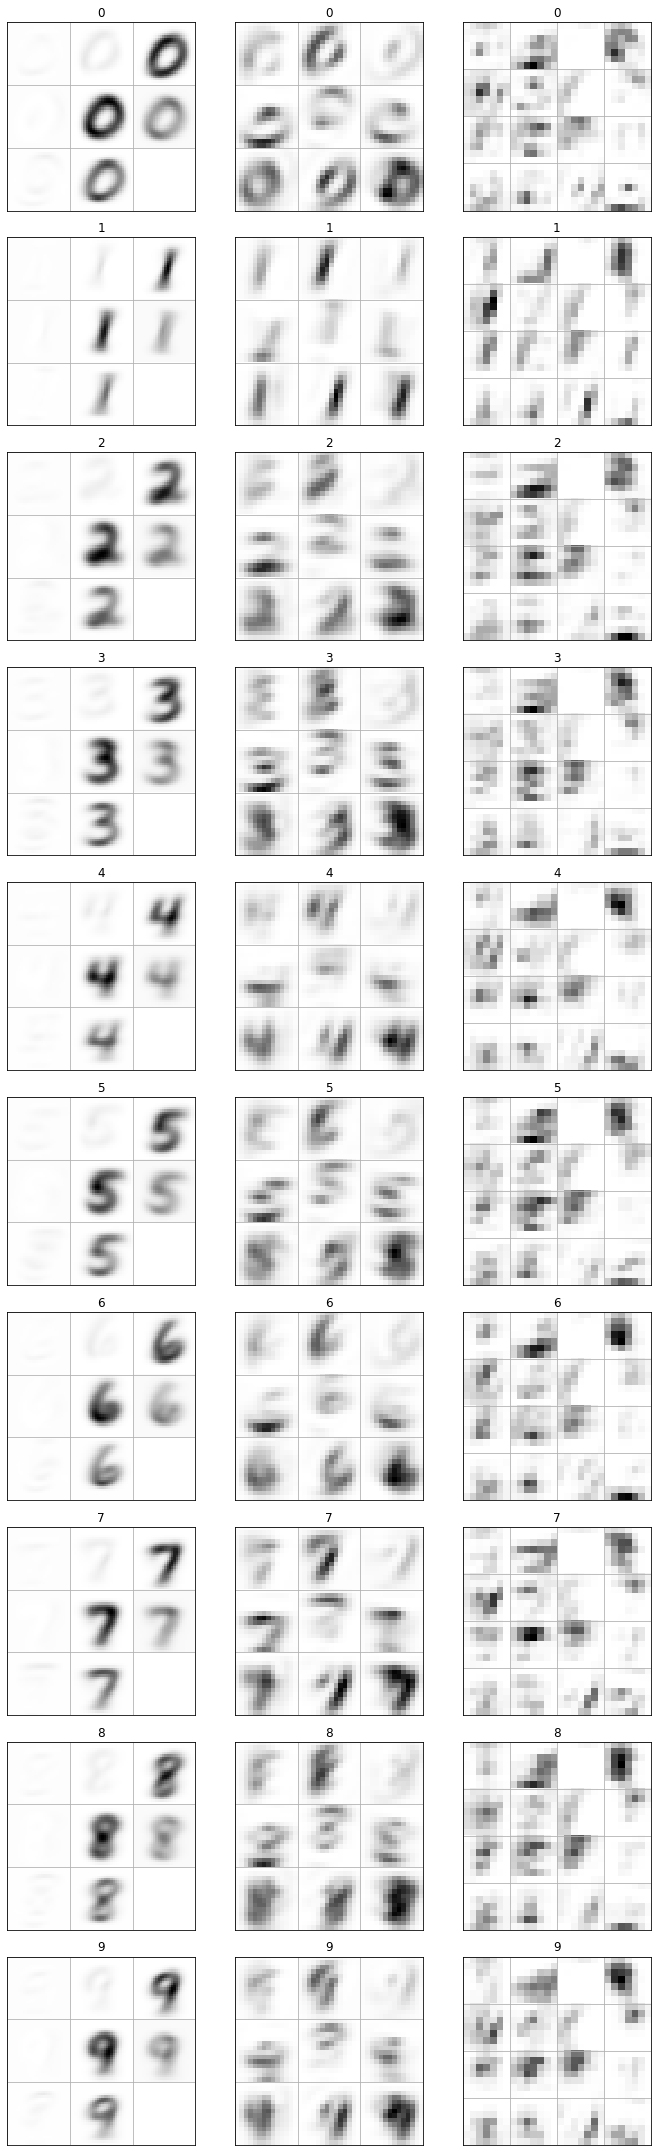

In [47]:
pl.figure(figsize=(10,30))
for i in np.arange(n_classes):
    pl.subplot(10,3,3*i+1)
    plot_conv_layer_output(all_l1_by_class[i,:,:,:], str(i))
    pl.subplot(10,3,3*i+2)
    plot_conv_layer_output(all_l2_by_class[i,:,:,:], str(i))
    pl.subplot(10,3,3*i+3)
    plot_conv_layer_output(all_l3_by_class[i,:,:,:], str(i))
pl.tight_layout()

### Visualize which filter is activated most of the time for each pixel
The following cells find the index of the filter with the highest activation, and then compute the mode through the whole dataset

In [48]:
l1_f = np.zeros((n_classes, ) + all_l1.shape[1:3])
for i in np.arange(n_classes):
    temp = np.argmax(all_l1[Y_train[:,i] == 1.0], axis=3)
    l1_f[i,:,:] = stats.mode(temp, axis=0)[0]
l2_f = np.zeros((n_classes,) + all_l2.shape[1:3])
for i in np.arange(n_classes):
    temp = np.argmax(all_l2[Y_train[:,i] == 1.0], axis=3)
    l2_f[i,:,:] = stats.mode(temp, axis=0)[0]
l3_f = np.zeros((n_classes,) + all_l3.shape[1:3])
for i in np.arange(n_classes):
    temp = np.argmax(all_l3[Y_train[:,i] == 1.0], axis=3)
    l3_f[i,:,:] = stats.mode(temp, axis=0)[0]

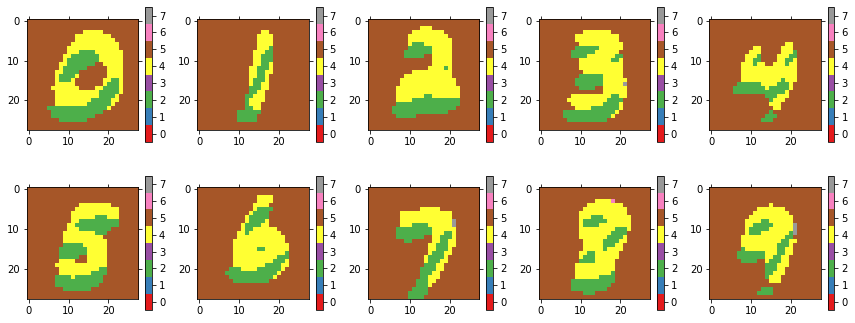

In [49]:
pl.figure(figsize=(12,5))
for i in np.arange(n_classes):
    pl.subplot(2,5,i+1)
    pl.imshow(l1_f[i], interpolation='nearest', cmap=pl.get_cmap('Set1', all_l1.shape[3]), vmin=0, vmax=all_l1.shape[3]-1)
    pl.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
    pl.colorbar(values=np.arange(all_l1.shape[3]),
                boundaries=np.arange(all_l1.shape[3]+1)-0.5,
                ticks=np.arange(all_l1.shape[3]), shrink=0.8)
pl.tight_layout()

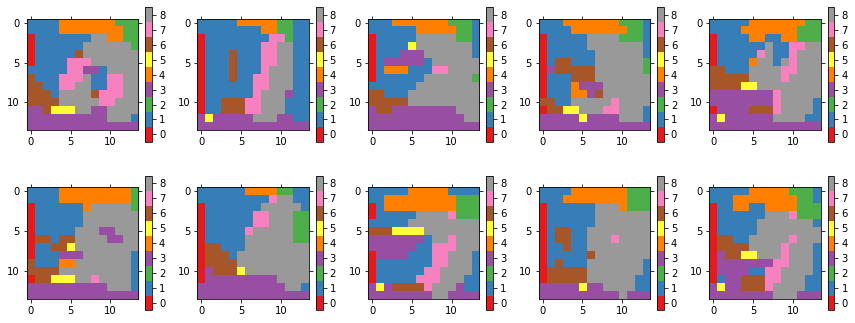

In [50]:
pl.figure(figsize=(12,5))
for i in np.arange(n_classes):
    pl.subplot(2,5,i+1)
    pl.imshow(l2_f[i], interpolation='nearest', cmap=pl.get_cmap('Set1', all_l2.shape[3]), vmin=0, vmax=all_l2.shape[3]-1)
    pl.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
    pl.colorbar(values=np.arange(all_l2.shape[3]),
                boundaries=np.arange(all_l2.shape[3]+1)-0.5,
                ticks=np.arange(all_l2.shape[3]), shrink=0.8)
pl.tight_layout()

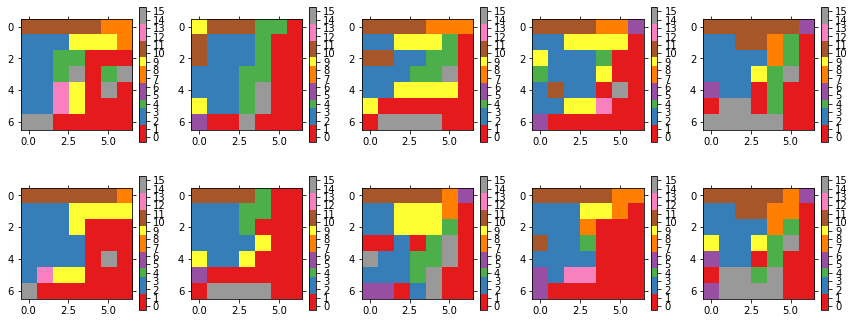

In [51]:
pl.figure(figsize=(12,5))
for i in np.arange(n_classes):
    pl.subplot(2,5,i+1)
    pl.imshow(l3_f[i], interpolation='nearest', cmap=pl.get_cmap('Set1', all_l3.shape[3]), vmin=0, vmax=all_l3.shape[3]-1)
    pl.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
    pl.colorbar(values=np.arange(all_l3.shape[3]),
                boundaries=np.arange(all_l3.shape[3]+1)-0.5,
                ticks=np.arange(all_l3.shape[3]), shrink=0.8)
pl.tight_layout()